## practicalRegress2

The goal of this part is to investigate the Bayesian approach to
regression

Work your way through these examples filling in code where it says
"TO DO"



In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy
from scipy import optimize
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib inline

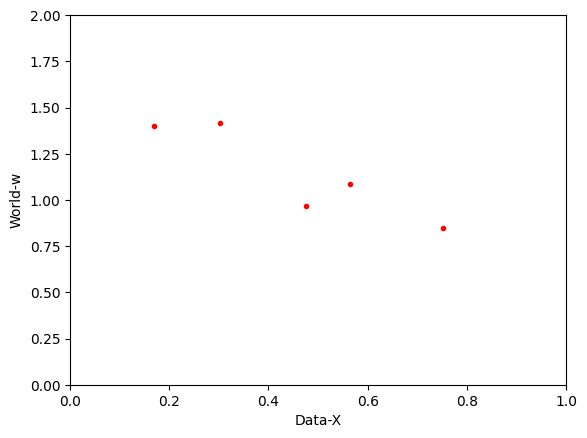

In [3]:
#set seeds for random number generators 
#so we get the same random numbers each time
np.random.seed(5)

#define actual parameters
offsetActual = 1.5  # this is phi_0 in the notes
slopeActual = -0.8  # this is phi_1 in the notes
noiseActual = 0.01  # this is sigma^2 in the notes

#generate some data 
nData = 5
X = np.random.rand(1,nData)
X = np.array([[0.5645,0.3024,0.7520,0.4752,0.1684]])

r_w = np.array([[ 0.3606, 1.5850,-0.4865,-1.5375,0.3576]])

w = offsetActual + slopeActual * X + np.sqrt(noiseActual) * r_w

#Transpose w so that it is a column vector like in the notes
w = w.transpose()

#Add a row of ones to the start of X
X = np.vstack([np.ones((1,X.shape[1])) ,X])  #X = [ones(1,size(X,2));X];
nDim = X.shape[0]

#display this data
fig=plt.figure()
plt.plot(X[1,:],w.squeeze(),'r.')
plt.xlabel('Data-X')
plt.ylabel('World-w')
fig.axes[0].set_xlim(0,1)
fig.axes[0].set_ylim(0,2)
plt.show()


In [6]:
#This function evaluates data against the multivariate normal distribution
def normalProb(X,normalMean,normCov):
    
    nDim,nData = X.shape
    
    if normalMean.ndim == 1:
        normalMean = normalMean[:,np.newaxis] # (N,) => (N,1)
        
    X = X - np.tile(normalMean, (1,nData)) 

    l = np.sum( inv(normCov)@X*X ,axis=0,keepdims=True) # (1,N)
    l = ( 1/np.sqrt(det(normCov)*((2*np.pi)**nDim) ))* np.exp(-0.5*l) 
    return l

         
#This function returns the negative log marginal likelihood
def negLogMarginalLike(logSigmaSq,X,w,sigmaPSq):

    sigmaSq = np.exp(logSigmaSq)
    
    L = normalProb( w, np.zeros_like(w), X.transpose()@X*sigmaPSq + np.eye(X.shape[1])*sigmaSq)
    L = -1 * np.sum(np.log(L))
    return L


#The goal of this routine is to take data X and w and the prior variance
#scale sigmaPSq and return the estimated variance of the linear regression model.  
#It does this by optimizing the marginal likelihood
def estNoiseParameter(X,w,sigmaPSq):

    # initial estimate for variance
    sigmaSqInit = np.var(w)
    
    # take logarithm (so optimization routine doesn`t have to constrain to be positive)
    logSigmaSqInit = np.log(sigmaSqInit)
    
    # minimizes the negative log marginal likelihood
    logSigmaSq = optimize.fmin(
        func=lambda logSigmaSq:negLogMarginalLike(logSigmaSq, X,w,sigmaPSq), x0=logSigmaSqInit, disp=False)
    
    # exponentiate to return to positive value
    sigmaSq = exp(logSigmaSq)

    return sigmaSq



### TODO  - fill in this routine (see cell below, fitLinearRegressionBayes)

In [15]:
#The goal of this routine is to take data X and w and the prior variance
#scale sigmaPSq and return the mean and covariance of the posterior
#distribution of the vector phi = [offset;slope];

def fitLinearRegressionBayes(X,w,sigmaSq,sigmaPSq):

    #retrieve dimensionality and number of data points 
    nDim, nData = X.shape
    
    #TODO compute A matrix (using either equation 8.11 or 8.13 from notes)
    if nDim > nData:
        # Using matrix inversion lemma form when D>N
        XtX = X @ X.T # X^T * X (NXN)
        I_nData = np.eye(nData) # Identitiy matrix of size N
        
        # Compute the inverse of smaller matrix (N x N)
        intermediate_matrix = XtX + (sigmaSq/sigmaPSq) * I_nData
        inverse_intermediate_matrix = np.linalg.inv(intermediate_matrix)
        
        # Compute A matrix using matrix inversion lemma
        A_inv = sigmaPSq * (I_nData - (sigmaSq/sigmaPSq) * X.T @ inverse_intermediate_matrix @ X)
    else:
        # Use the direct form when D <= N
        A = (1/sigmaSq) * (X @ X.T) + (1/sigmaPSq * np.eye(nDim))
        A_inv = np.linalg.inv(A)
    
    if not (A.shape[0] == nDim and A.shape[1] == nDim):
        raise ValueError('A should be a square matrix, size nDim x nDim')
    else:
        pass

    #TODO compute posterior mean and variance of phi vector (contains offset and slope)
    #REPLACE THIS:
    posteriorPhiMean = (1/sigmaSq) * inv(A) @ X @ w
    posteriorPhiCov = np.linalg.inv(A)
    
    
    #checking sizes of output values are correct
    if not ( posteriorPhiCov.shape[0] == nDim and posteriorPhiCov.shape[1] == nDim):
        raise ValueError('posteriorPhiCov should be a nDim x nDim matrix')
    elif not ( posteriorPhiMean.squeeze().ndim == 1 and posteriorPhiMean.size == nDim):
        raise ValueError('posteriorPhiMean should be a nDim x 1 vector')
    else:
        pass

    return posteriorPhiMean,posteriorPhiCov,A


In [16]:
#define a normal prior on the slope and offset parameters
sigmaPSq = 1

priorPhiMean = np.zeros([nDim,1])
priorPhiCov = np.eye(nDim)*sigmaPSq

#fit the noise parameter to the model 
#I've done this for you , but you should check out how it works
sigmaSq= estNoiseParameter(X,w,sigmaPSq)

#now the problem is to fit the data - we find a normal  probability distribution
#over the parameter vector phi
posteriorPhiMean,posteriorPhiCov,A = fitLinearRegressionBayes(X,w,sigmaSq,sigmaPSq)


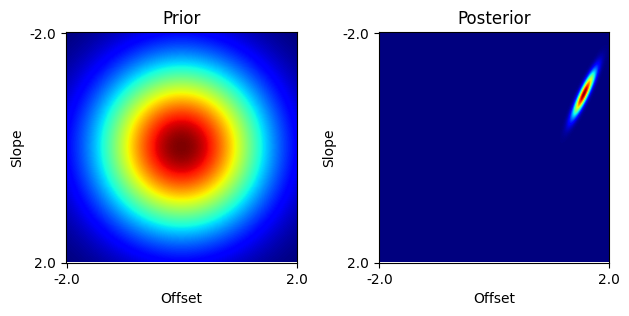

In [18]:
#****************************************************************
#display the prior and posterior over the parameters
#create arrays of x and w positions
xFigRange =np.arange(-2,2.001,step=0.01) # -2.0:0.01:2.0;
wFigRange =np.arange(-2,2.001,step=0.01) # -2.0:0.01:2.0;

xFig = np.tile(xFigRange[np.newaxis,:] , (wFigRange.size,1))
wFig = np.tile(wFigRange[:,np.newaxis] , (1,xFigRange.size))

#evaluate the Gaussians before and after
xwDrawData = np.vstack([xFig.flatten(),wFig.flatten()])

prior = normalProb(xwDrawData,priorPhiMean,priorPhiCov)
prior = np.reshape(prior,xFig.shape)

posterior = normalProb(xwDrawData,posteriorPhiMean,posteriorPhiCov)
posterior = np.reshape(posterior,xFig.shape)

fig=plt.figure()
ax1=plt.subplot(1,2,1) 
plt.imshow(prior) 
plt.xlabel("Offset")
plt.ylabel("Slope")
plt.title("Prior")
plt.axis('image')
plt.set_cmap('jet')
ax1.set_xticks([1,xFigRange.size])
ax1.set_yticks([1,wFigRange.size])
ax1.set_xticklabels(['-2.0','2.0']) 
ax1.set_yticklabels(['-2.0','2.0']) 

ax2=plt.subplot(1,2,2)
plt.imshow(posterior) 
plt.xlabel("Offset")
plt.ylabel("Slope")
plt.title("Posterior")
plt.axis('image') 
plt.set_cmap('jet')
ax2.set_xticks([1,xFigRange.size])
ax2.set_yticks([1,wFigRange.size])
ax2.set_xticklabels(['-2.0','2.0']) 
ax2.set_yticklabels(['-2.0','2.0']) 

# Prevent subplots from bunching up
plt.tight_layout()

plt.show()
#****************************************************************

** Let's draw a figure to show the posterior probability of the world as a function of the data **

In [23]:
predMean= np.zeros((XStar.shape[1]))
predMean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

C:\Users\44774\AppData\Local\Temp\ipykernel_26912\199717713.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predMean[cX] = posteriorPhiMean.T @ x_star


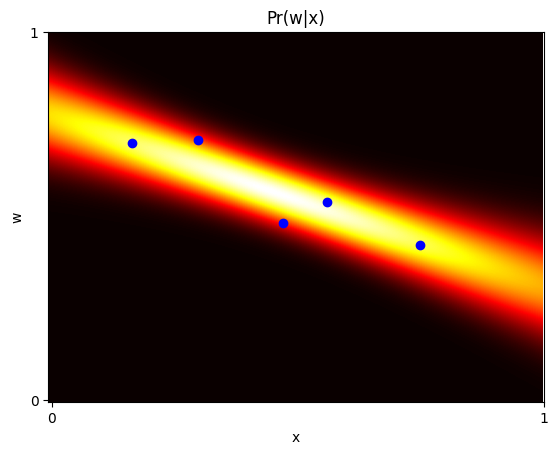

In [28]:
#For every xStar, the model predicts a normal distribution over w
XStar = np.arange(0,1.0001,step=0.005)

#Add ones to the start of XStar
XStar = np.vstack([np.ones_like(XStar),XStar])
nDim,nData = XStar.shape

# TODO 
# Compute the mean and variance of the posterior over w 
# for each element of X2.

# Initialize predicted mean and variance
# Given posteriorPhiMean and posteriorPhiCov
# dimension of both mean and variance are 1 x 1 scalar
predMean= np.zeros((XStar.shape[1]))
predVar=np.zeros((XStar.shape[1]))

for cX in range(XStar.shape[1]):
    x_star = XStar[:, cX] # current X_star
    # Compute the predicted mean for the current X_star
    predMean[cX] = posteriorPhiMean.T @ x_star 
    predVar[cX] = noiseActual + x_star.T @ posteriorPhiCov @ x_star
        
# checking predMean and predVar are of the correct dimensions
if not (predMean.squeeze().ndim ==1 and predMean.size == XStar.shape[1] ):
    raise ValueError('predMean should be a vector of same length as XStar')
elif not ( predVar.squeeze().ndim ==1 and predVar.size == XStar.shape[1] ):
    raise ValueError('predVar should be a vector of same length as XStar')
else:
    pass

#compute the pixel colours for the image - one Gaussian in each column
wFig = np.arange(0,2.0001,step=0.005) #0:0.005:2;
postFun = np.zeros((wFig.size, XStar.shape[1]))

for cX in range(XStar.shape[1]):
    postFun[:,cX] = (1 / np.sqrt(2*np.pi*predVar[cX]))
    postFun[:,cX] = postFun[:,cX] * np.exp(-0.5 * ((wFig-predMean[cX])**2) / predVar[cX] )

# draw the figure
fig=plt.figure()
plt.imshow(postFun)
plt.set_cmap('hot')
plt.gca().invert_yaxis() 

plt.plot((X[1,:]-XStar[1,0])/(XStar[1,1]-XStar[1,0]), ((w.transpose()-wFig[0])/(wFig[1]-wFig[0])).squeeze(),'bo')
#draw the units on the graph
ax0=fig.axes[0]
ax0.set_xticks([1,XStar.shape[1]])
ax0.set_xticklabels([0,1])
ax0.set_yticks([1,wFig.size])
ax0.set_yticklabels([0,1])
ax0.set_aspect('auto')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Pr(w|x)')

plt.show()


### TO DO (AT HOME IF YOU ARE KEEN): 
Convert this to non-linear regression by passing the data
through a non-linear transformation.  
When you do this you'll have to 
comment out the section between the \#\*\*\*\*\* #\*\*\*\*\* as the prior and posterior
are no longer 2 dimensional.
You'll also have to load in the non-linear data and make sure that the
final plot is drawn with sensible axes.